# A) Make grid of ice base

- tiff of ice thickness is from DATA/Jupyter/RADAR/RADAR_MAP/20_RADAR_interpolate_channel_background_separate_wholechannel.ipynb


1. Get the coordinates from ice thickness grid
2. sample at these coords from REMA
3. subtract sampled surface from ice thickness

4. Could save to tif following process in 20_RADAR... i havent yet

# B) Get ice base related to interpolated lines (not gridded)


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import glob
import os
import sys
import time
import datetime as dt
import pandas as pd
import geopandas as gpd
import scipy as sp
from scipy import signal
from tqdm.notebook import tqdm
import rasterio as rio

from shapely.geometry import Point, LineString, Polygon, MultiPoint
import fiona
from shapely.ops import nearest_points

In [5]:
bed_gdf = gpd.read_file('/Volumes/arc_04/FIELD_DATA/K8621920/RES/PROCESSED_LINES/picked_bed.shp')

In [6]:
ice_thickness_path = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/thickness_line2line.tif'
REMA_path = '/Volumes/arc_02/whitefar/DATA/REMOTE_SENSING/REMA_STRIPES/SETSM_WV01_20161109_1020010058134D00_10200100576C9100_seg1_2m_v1.0_dem.tif'

In [38]:
ice_thickn = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchanice_thickness.npy')

### 1) get coordinates of interpolated thickness tiff

In [39]:
# or could have just done 
# xv = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchanx_grid.npy')

In [7]:
with rio.open(ice_thickness_path) as image:
#     extent_tiffout = image.bounds[0]
    extent_ice_thickn= [image.bounds[0],image.bounds[2],image.bounds[1],image.bounds[3]]
    im_ice_thickn = image.read(1)/100

In [41]:
x = np.linspace(extent_ice_thickn[0],extent_ice_thickn[1],im_ice_thickn.shape[1]).astype('int')
y = np.linspace(extent_ice_thickn[3],extent_ice_thickn[2],im_ice_thickn.shape[0]).astype('int')
x_c = np.linspace(extent_ice_thickn[0],extent_ice_thickn[1],im_ice_thickn.shape[1]).astype('int')
y_c = np.linspace(extent_ice_thickn[3],extent_ice_thickn[2],im_ice_thickn.shape[0]).astype('int')

In [42]:
xv_ice_thickn, yv_ice_thickn = np.meshgrid(x_c, y_c)

### 2) sample from REMA at these coordinates

In [10]:
with rio.open(REMA_path) as src:
    
    coords = [(x,y) for x, y in zip(xv_ice_thickn.flatten(), yv_ice_thickn.flatten())]

    elevations = [elevation[0] for elevation in src.sample(coords)]

In [14]:
# REMA surface on the ice_thickness coordinates
REMA_surf = np.array(elevations).reshape(xv_ice_thickn.shape)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan_REMA_sampled.npy',REMA_surf)

In [22]:
ice_base = REMA_surf - ice_thickn

In [23]:
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan_ice_base.npy',ice_base)

In [9]:
# ice_base = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan_ice_base.npy')
# extent_ice_thickn = [-383038.0, -374784.0, -734075.0, -721771.0]

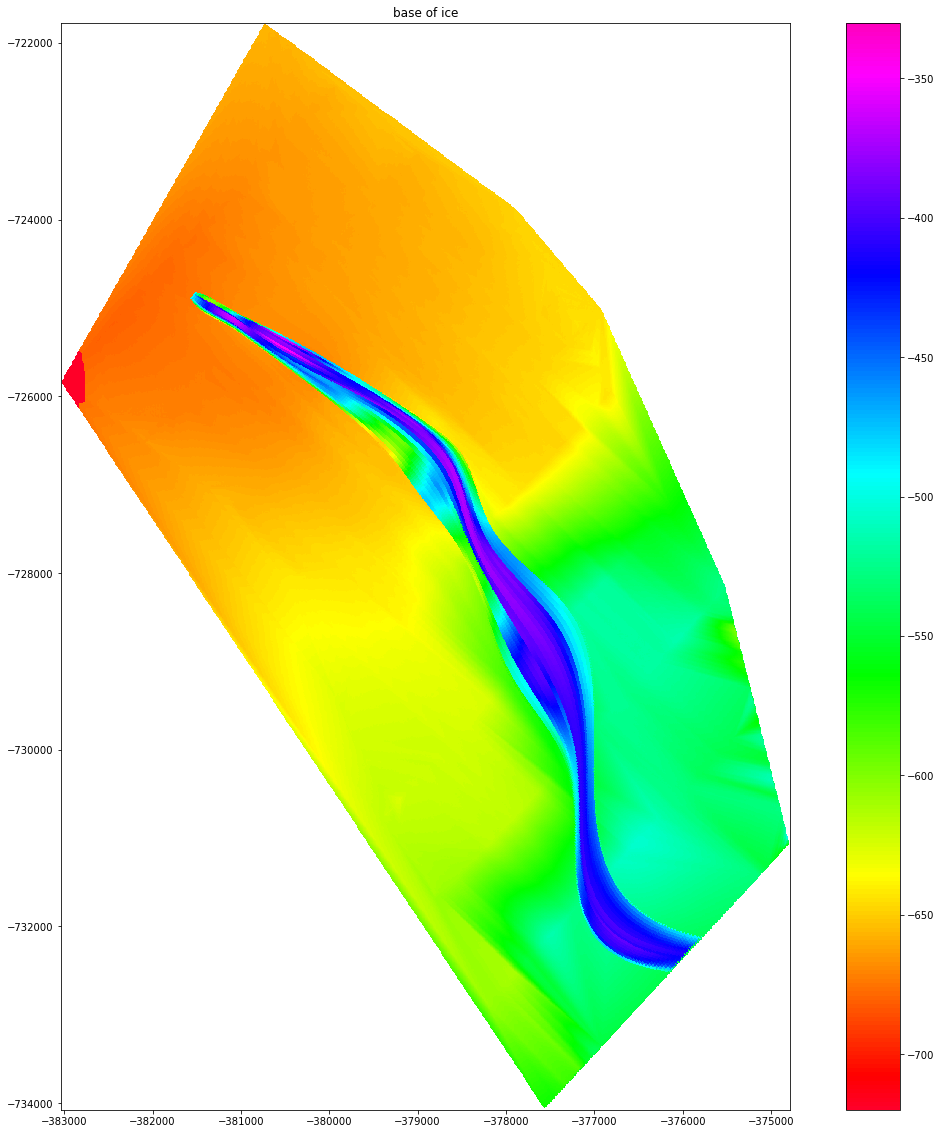

In [14]:
# %matplotlib qt

plt.figure(figsize=(20,20))

plt.imshow(ice_base,vmin= -720 ,vmax =-330,  extent=extent_ice_thickn,cmap='gist_rainbow')
# plt.xlim([ -382000.0,-381000])
# plt.ylim([-726000.0, -724000.0])
plt.colorbar()
plt.title('base of ice')


plt.show()

# B) Get ice base related to interpolated lines (not gridded)

1. Get the coordinates from ice thickness interpolated
2. sample at these coords from REMA
3. subtract sampled surface from ice thickness
4. save


In [44]:
points_x = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_x.npy')
points_y = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_points_y.npy')
ice_thickn = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_ice_thickn.npy')

In [46]:
with rio.open(REMA_path) as src:
    
    coords = [(x,y) for x, y in zip(points_x.flatten(), points_y.flatten())]

    surface_interp_flat = [elevation[0] for elevation in src.sample(coords)]

In [48]:
surface_interp = np.array(surface_interp).reshape(points_x.shape)
base_of_ice = surface_interp - ice_thickn

In [49]:
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_REMAsurf.npy',surface_interp)
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/channel_line2line_interpbydist_icebase.npy',base_of_ice)

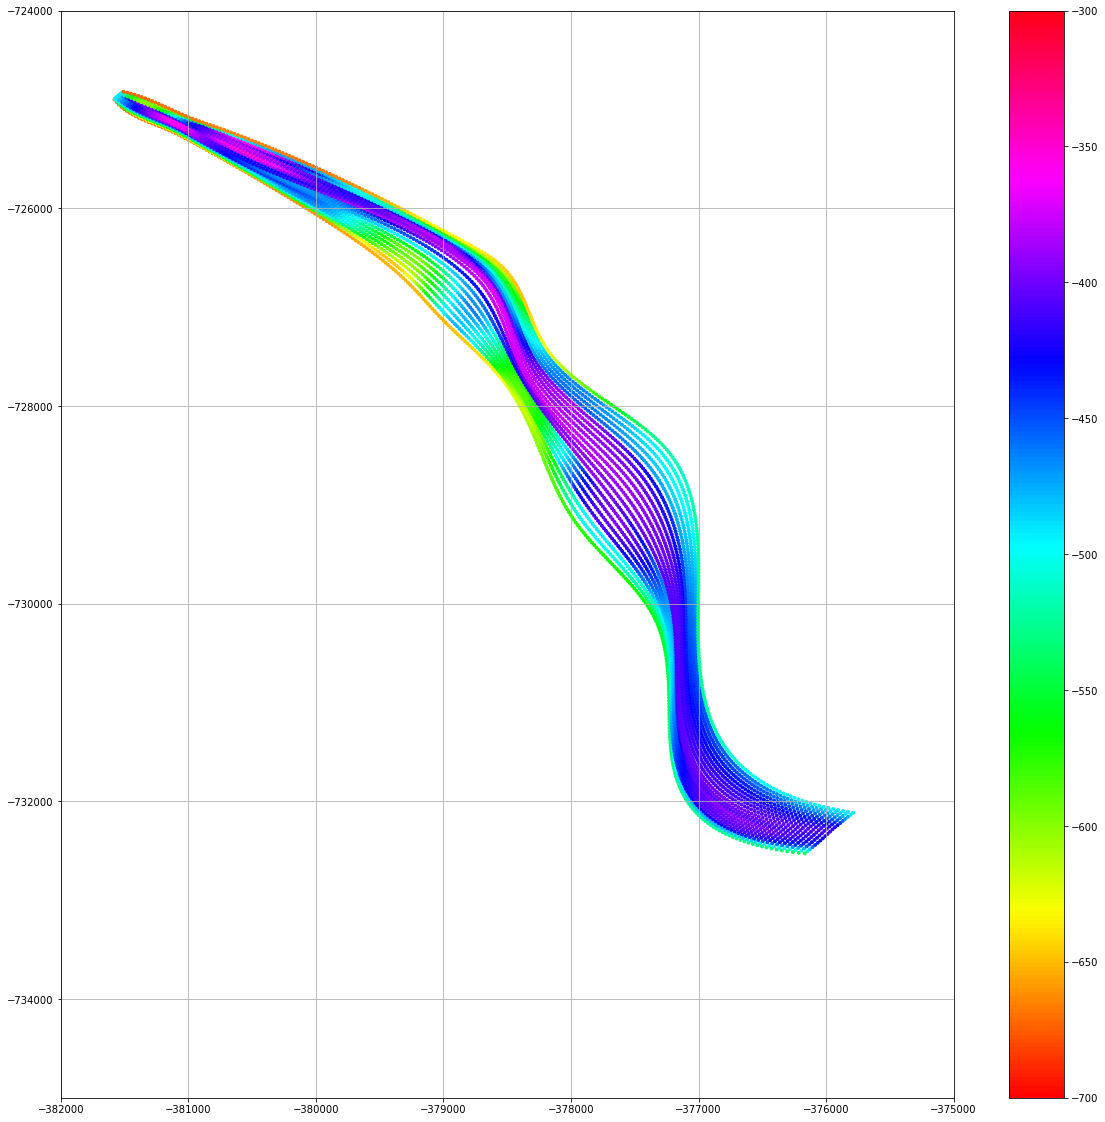

In [55]:
plt.figure(figsize=(20,20))
plt.scatter(points_x,points_y,c=base_of_ice,s=8,cmap='hsv',vmin=-700, vmax=-300)
plt.xlim([-382000, -375000])
plt.ylim([-735000,-724000])
plt.colorbar()
plt.grid()
# plt.title('interpd channel and old and new radar lines')

# repeat for surveyed points

In [56]:
points_x_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_x_channel.npy')
points_y_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/points_y_channel.npy') 
ice_thickn_surveyed = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/ice_thickn_channel.npy')

In [59]:
with rio.open(REMA_path) as src:
    
    coords = [(x,y) for x, y in zip(points_x_surveyed.flatten(), points_y_surveyed.flatten())]

    surf_surveyed = [elevation[0] for elevation in src.sample(coords)]

In [60]:
surf_surveyed = np.array(surf_surveyed).reshape(points_x_surveyed.shape)
base_of_ice = surf_surveyed - ice_thickn_surveyed

In [61]:
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/surf_channel.npy',surf_surveyed )
np.save('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/bed_channel.npy',base_of_ice )

## save to tiff

In [47]:
direc = '/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan'

xv = xv_ice_thickn
yv = yv_ice_thickn
ice_base = np.load('/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/interpolatedgrid_allchan_ice_base.npy')
extent = np.load(direc +'extent.npy')
# surf_out = np.load(direc +'surface.npy')

In [48]:
# x_scale = -(xmin-xmax)/x_length  # this should be pixel size
x_scale = -(xv[0,0]-xv[0,-1])/xv.shape[1]    
y_scale = -(yv[0,0]-yv[-1,0])/yv.shape[0]   

# x_scale = 40
# y_scale = 40

out_meta = {'driver': 'GTiff',
            'dtype': 'float64',
             'nodata': np.nan,
             'width': ice_base.shape[1],
             'height': ice_base.shape[0],
             'count': 1,
             'crs': rio.crs.CRS.from_dict(init='epsg:3031'),
             'transform': rio.Affine(x_scale, 0.0, xv[0,0],0.0, y_scale, yv[0,0])}

In [49]:
print(out_meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': nan, 'width': 4128, 'height': 6153, 'count': 1, 'crs': CRS.from_dict(init='epsg:3031'), 'transform': Affine(1.999515503875969, 0.0, -383038.0,
       0.0, -1.9996749553063546, -721771.0)}


In [50]:
#write the cropped tiff of ICE THICKNESS to file
with rio.open("/Users/home/whitefar/DATA/FIELD_ANT_19/POST_FIELD/RADAR_MAP/ice_base_line2line.tif", "w", **out_meta) as dest:
    dest.write(ice_base.reshape(1,ice_base.shape[0],ice_base.shape[1])   )

In [26]:
extent

array([-383037.7, -374781.9, -734075.1, -721770.2])